# **CS684 Project Report**

Yutao (Frank) Han y326han@uwaterloo.ca

# Introduction

The rapid growth of digital images in recent years has led to an increasing demand for effective and efficient image classification techniques. In many practical scenarios, however, acquiring a large amount of labeled data for training supervised classifiers can be difficult and expensive. This challenge has led to the development of semi-supervised learning approaches, which aim to leverage both labeled and unlabeled data to improve classification performance. In this report, we present a novel semi-supervised image classification method designed to benefit from unlabeled examples in the training dataset.

Our project focuses on the problem of semi-supervised image classification, where only M out of N images in the training data have ground truth labels. We implement a weakly supervised training framework for a classification network that can exploit the information present in unlabeled examples. For our experiments, we use the standard dataset CIFAR-10 while ignoring labels on a subset of training examples. We investigate how the performance of our proposed method changes as M gets progressively smaller, shedding light on the effectiveness of our approach in low-label data scenarios.

# Group Members and Contributions
- Yutao (Frank) Han: y326han@uwaterloo.ca
  - Contribute to the base code. Start up the fundemental Pseudo-Labelling structure training and create the basic CNN model
  - Run experiments for Pseudo-Labelling
  - Rearrange the codes, add comments and texts to improve the readability of the report
- Renjie Ni: r6ni@uwaterloo.ca
  - Contribute to the improvement of Pseudo-Labelling structure training, and build the Resnet-Kmeans structure and training.
  - Run experiments for Pseudo-Labelling and Resnet-Kmeans
  - Organize and analyze experimental results, and write the corresponding sections of the report.

# Methodology

We tried two different approaches to inplement the semi-supervised image classification:  Pseudo-Labelling model and Resnet-Kmeans model.

## Pseudo-Labelling(modified Teacher-student model)
Firstly, we have chosen a relatively simple structure called pseudo-labeling. Its core idea is to utilize a model already trained on labeled data to predict the labels for unlabeled data. These predicted pseudo-labels are then combined with the true labels as training data to further train the model. To make our description more vivid and easier to understand, we prefer to call this model a modified teacher-student model where the teacher aims to train a student that surpasses its own performance using the unlabeled data. The student then becomes the new teacher, and the process is repeated. 
Here is the procedure for training:
1. Create a `Teacher` model, train it with the labeled data.
2. Use the `Teacher` model to predict the unlabled data and create pseudo-label for them (collect ones that above threshold).
3. For each pseudo-label, we only chose the top 250 data with high probability.
4. Create a `Student` model, train it with the predicted data.
5. If `Student`'s performance is better than `Teacher`, then we use the this `Student` as next `Teacher` and repeat step 2-5. Also, it means that the prediction taht this `Student` made is strong confident, so we move the prediction of this time to labled data. Make sure they are removed from unlabled data to avoid repeating.
6. The training will stop when the performance of `Student` doesn't improve a lot in a certain times.

## Resnet-Kmeans
The second model we have chosen is a semi-supervised model that combines ResNet and KMeans, which we call the ResNet-KMeans model. Unlike pseudo-labeling, which aims to expand the labeled dataset, its core idea is to combine the cross-entropy loss on labeled data points with the (unsupervised) K-means clustering loss over deep features (e.g., in the last layer before the linear classifier).

Here is the procedure for training:

1. Create a `supervised model` (ResNet) and train it with the labeled data.
2. Extract the `deep features` (e.g., in the last layer before the linear classifier) and use them to train a `K-means model`.
3. Combine the `cross-entropy loss` from ResNet and the `K-means clustering loss` to form a new loss.
4. Perform `backward propagation` based on the new loss and update the supervised model.
5. Repeat this procedure until the performance of the supervised model does not improve significantly within a certain number of iterations.

# Experiment

## Common codes

Here are common codes including import definitions of class or functions used by both 2 methods.

### Import modules

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import copy
from copy import deepcopy
from google.colab import drive
from collections import defaultdict
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset

import pandas as pd
import matplotlib.pyplot as plt

### Connected to google drive

In [ ]:
# For testing, you do not need to run this cell
drive.mount('/content/drive')
project_folder = "/content/drive/MyDrive/cs484-project"
os.chdir(project_folder)

Mounted at /content/drive


### Global variable settings

In [ ]:
EPOCHES = 20
BATCHES = 100
WORKERS = 4

MODEL_SAVE_PATH = "./saved_model"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)

### Definition of the CNN model
We first try with normal CNN, but it does not have a very good performance.

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(    
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x  

### Definition of Resnet
We fianlly try ResNet to be the model for training

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
      super(ResNet, self).__init__()
      self.in_channels = 32
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(32)
      self.relu = nn.ReLU(inplace=True)
      self.layer1 = self.make_layer(BasicBlock, 32, num_blocks[0], stride=1)
      self.layer2 = self.make_layer(BasicBlock, 64, num_blocks[1], stride=2)
      self.layer3 = self.make_layer(BasicBlock, 128, num_blocks[2], stride=2)
      self.layer4 = self.make_layer(BasicBlock, 256, num_blocks[3], stride=2)
      self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

    def forward_features(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        features = out.reshape(out.shape[0], -1)
        
        return features
        

    def features(self, x):
        return self.forward_features(x)

    def classifier(self, features):
        return self.fc(features)

        

### Definition of CIFARData
This class is created based on CIFAR-10 dataset. All images are size of 32x32. It has 50000 images for training and 10000 images for testing. We split the training images into two groups: one trains the model with label and the another one we ignore the labels.

In [ ]:
class CIFARData():
    def __init__(self, batch_size, num_workers, label_ratio):
        cifar10_path = "./data/cifar10"
        download = True
        
        # check if dataset has been downloaded
        if os.path.isdir(os.path.join(cifar10_path, "cifar-10-batches-py")):
            download = False

        # Define the transforms for train data augmentation
        train_transform = transforms.Compose([
            transforms.RandomCrop(24, padding=2),
            transforms.RandomRotation(23),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Resize(32, antialias=True)
        ])

        # Define the transforms for test data augmentation
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Resize(32, antialias=True)
        ])

        # obtain the train and test dataset
        train_dataset = datasets.CIFAR10(root=cifar10_path, train=True, download=download, transform=train_transform)
        test_dataset = datasets.CIFAR10(root=cifar10_path, train=False, download=download, transform=test_transform)

        # shuffle the train_dataset to improve generalization
        train_size = len(train_dataset)
        train_indices = np.arange(train_size)
        np.random.shuffle(train_indices)

        # let 10% train data be the labeled, rest are unlabeled
        split_pos = int(train_size * label_ratio)
        labeled_train_indices = train_indices[:split_pos]
        unlabeled_train_indices = train_indices[split_pos:]

        # seperate the train_data set to labeled and unlabeled
        labeled_dataset = Subset(train_dataset, labeled_train_indices)
        unlabeled_dataset = Subset(train_dataset, unlabeled_train_indices)

        labeled_train_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        unlabeled_train_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.labeled_train_loader = labeled_train_loader
        self.unlabeled_train_loader = unlabeled_train_loader
        self.test_loader = test_loader
        self.train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



### Definition of CustomDataset
This class is used for creating our own dataset (based on python list).

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


### Definition of CombinedDataset
This class is used to combined labeled and unlabeled data. For unlabeled data, we return its label as -1

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, labeled_data, unlabeled_data):
        self.labeled_data = labeled_data.dataset
        self.unlabeled_data = unlabeled_data.dataset

    def __getitem__(self, idx):
        if idx < len(self.labeled_data):
            return self.labeled_data[idx]
        else:
            data, _ = self.unlabeled_data[idx - len(self.labeled_data)]
            return data, -1

    def __len__(self):
        return len(self.labeled_data) + len(self.unlabeled_data)

### Definition of some help functions
1. listToDataloader: convert a list of tuple (data, label) to a Dataloader
2. indiceSubsetDatalodaer: give dataloader, we extract the data indicated by indices and return a new dataloader
3. concatDataloader: concat two dataloaders to form a new dataloader

In [ ]:
def listToDataloader(data_list, batch_size, num_workers):
    dataset = CustomDataset(data_list)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


def indiceSubsetDatalodaer(dataloader, indices):
    batch = dataloader.batch_size
    worker = dataloader.num_workers

    origin_dataset = dataloader.dataset
    new_dataset = Subset(origin_dataset, indices)
    dataloader = DataLoader(new_dataset, shuffle=True, batch_size=batch, num_workers=worker)
    return dataloader


def concatDataloader(data1, data2, has_unlabel=False):
    dataloader = None
    batch = data1.batch_size
    worker = data1.num_workers

    if has_unlabel:
        combined_data = CombinedDataset(data1.dataset, data2.dataset)
        dataloader = DataLoader(combined_data, shuffle=True, batch_size=batch, num_workers=worker)
    else:
        combined_data = ConcatDataset([data1.dataset, data2.dataset])
        dataloader = DataLoader(combined_data, shuffle=True, batch_size=batch, num_workers=worker)

    return dataloader

### Definition of `train()`
This function trains the model with given dataloader (data with label), criterion, and optimizer.       \
Return the best loss during training. Basically it's supervised training.

In [ ]:
def train(model, dataloader, criterion, optimizer, epochs=20):
    model.to(DEVICE)
    model.train()

    for epoch in range(epochs):
        best_train_loss = 0
        curr_train_loss = 0
        msg_len = 0

        for batch_idx, (data, label) in enumerate(dataloader):
            data, label = data.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            curr_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            if ((batch_idx+1) % 10 == 0):
                print(' ' * msg_len, end='\r')      # clean current line
                databatch_count = len(dataloader)
                percent = float(batch_idx / databatch_count * 100)
                msg = "Epoch: {}, Progress: {}/{} ({:.1f}%)".format(
                    epoch+1, batch_idx+1, databatch_count, percent)
                print(msg, end='\r')
                msg_len = len(msg)

        data_count = len(dataloader.dataset)
        curr_train_loss /= data_count
        
        if epoch == epochs - 1:
          print("Loss on the training data: {}".format((curr_train_loss)))

        if (curr_train_loss < best_train_loss):
            best_train_loss = curr_train_loss

    return best_train_loss




### Definition of `test()`
This function tests the model's performance with given dataloader and criterion.        \
Return the final test loss and accuracy

In [ ]:
def test(model, dataloader, criterion):
    model.to(DEVICE)
    model.eval()
    test_loss = 0
    correct = 0
    
    print("Testing starts...")
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            output = model(data)
            loss = criterion(output, label)
            test_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(label).sum()

    data_count = len(dataloader.dataset)
    test_loss /= data_count
    accuracy = float(correct / data_count * 100)
    print("Test result - Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n".format(
        test_loss, correct, data_count, accuracy))
    
    return test_loss, accuracy


    

### Definition of `predict()`
This function uses a model to predict the label for unlabeled data.         \
Return the dataloader of `(data, predicted label)` within given threshold and a list of indices of data that are not chosen as good prediction

In [ ]:
def predict(model, dataloader, threshold):
    model.to(DEVICE)
    model.eval()
    msg_len = 0

    # result will be list of tuple (data, label)
    result = []

    # the indices of not predicting properly data in dataset
    unused_indices = []

    # sample_data is a dict of list, format is
    #   label: [data_idx, probability of this data belongs to this label]
    sample_data = defaultdict(list)

    # predict the label by given model, for each data use its topk possible
    #   label, then put them into sample_data
    print("Prediction starts...")
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(DEVICE)

            output = model(data)
            softmax_output = F.softmax(output, dim=-1)
            topk, topk_idx = softmax_output.topk(k=10, dim=1)

            data = data.cpu()
            topk = topk.cpu()
            topk_idx = topk_idx.cpu()

            for idx in range(topk_idx.size(0)):
                has_good_pred = False
                for i, label in enumerate(topk_idx[idx]):
                    if topk[idx][i] > threshold:
                        curr = data[idx]
                        sample_data[label.item()].append((curr, topk[idx][i]))
                        has_good_pred = True
                if has_good_pred == False:
                  curr_idx = batch_idx * BATCHES + idx
                  unused_indices.append(curr_idx)

    
    # now base on sample_data, for each label, let the first 100
    #   data (sort in probability) that own this label
    print("\nPacking prediction result...", end='')
    for label in sample_data:
        sort_func = lambda x: x[1]  # x[1] is the probability
        chosen = sorted(sample_data[label], key=sort_func, reverse=True)[:250]
        for data_prob_pair in chosen:
            result.append((data_prob_pair[0], label))
    print("Done\n")

    predict = listToDataloader(result, BATCHES, WORKERS)

    return predict, unused_indices



### Definition of getBestTeacher()
Either load the saved best teacher model or train a new one.        \
Return the teacher model and its test accuracy.

In [ ]:
def getBestTeacher(is_train, label_data, test_data):
    teacher = ResNet([2, 2, 2, 2])

    train_loss = 0
    test_loss = 0
    test_accuracy = 0
    teacher_path = os.path.join(MODEL_SAVE_PATH, "best_teacher_model_{}.pt".format(DEVICE))
    find_save = os.path.exists(teacher_path)

    if find_save:
        # load from saved model
        checkpoint = torch.load(teacher_path)

    if not is_train:
        # check if we have model saved
        if not find_save:
            print("Saved teacher model is not detected, start training a new one...")
            is_train = True
        
    if is_train:
        # train teacher model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(teacher.parameters(), lr=0.001)
        print("Teacher starts to be trained with labeled data...")
        train_loss = train(teacher, label_data, criterion, optimizer)
        test_loss, test_accuracy = test(teacher, test_data, criterion)

        state = {
            "model": teacher.state_dict(), 
            "train_loss": train_loss,
            "test_loss": test_loss,
            "accuracy": test_accuracy
        }

        if find_save:
            # if this train result is better, we update the old checkpoint
            saved_accuracy = checkpoint["accuracy"]
            if (test_accuracy > saved_accuracy):
                torch.save(state, teacher_path)
        else:
            # if no checkpoint, save one
            torch.save(state, teacher_path)
    else:
        print("Load saved Teacher model...")
        teacher.load_state_dict(checkpoint["model"])
    
    return teacher, test_accuracy

## Proof that our supervised model is good enough on the CIFARData
We use all training data as label to show our model is suitable for CIFARData

In [ ]:
full_data = CIFARData(batch_size=BATCHES, num_workers=4, label_ratio=0.99)
full_label_data = full_data.labeled_train_loader
full_test_data = full_data.test_loader

# full_model = ImageClassifierCNN()        # we tried the other CNN before but didn't show a good performance
full_model = ResNet(num_blocks=[2, 2, 2, 2])
full_optimizer = optim.Adam(full_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

full_model_loss = train(full_model, full_label_data, criterion, full_optimizer)
full_test_loss, full_test_accuracy = test(full_model, full_test_data, criterion)

Epoch: 1, Loss: 0.01624630845195115
Epoch: 2, Loss: 0.012837725024030666
Epoch: 3, Loss: 0.011498009484223646
Epoch: 4, Loss: 0.010485120406054487
Epoch: 5, Loss: 0.00970223133130507
Epoch: 6, Loss: 0.009034303588096542
Epoch: 7, Loss: 0.008509872717086715
Epoch: 8, Loss: 0.008138865764694985
Epoch: 9, Loss: 0.0077260920086292305
Epoch: 10, Loss: 0.007438626713824995
Epoch: 11, Loss: 0.007119861260207012
Epoch: 12, Loss: 0.006918724930647648
Epoch: 13, Loss: 0.006635727194222537
Epoch: 14, Loss: 0.006465777035313423
Epoch: 15, Loss: 0.006213168660799662
Epoch: 16, Loss: 0.0061056578279745696
Epoch: 17, Loss: 0.005908723353737533
Epoch: 18, Loss: 0.005801944066779782
Epoch: 19, Loss: 0.00561020906284602
Epoch: 20, Loss: 0.005477223042285804
Testing starts...
Test result - Average loss: 0.0078, Accuracy: 7589/10000 (75.9%)



## First experiment: Training with the Pseduo Labelling method

### Definition of `train_teacher_student` 
This function uses Pseudo-Labelling structure training method. `label_ratio` is the ratio of labeled data to entire CIFAR-10 training data, `save_student` decide if save final best student model and `identify` is for customizing the name of saved model. The name will be `best_student_model_{identify}.pt`

In [ ]:
def train_teacher_student(label_ratio, save_student=True, identify=""):
    threshold = 0.9
    acc_threshold = 0.3
    stop_threshold = 3

    dataloader = CIFARData(batch_size=BATCHES, num_workers=WORKERS, label_ratio=label_ratio)
    label_data = dataloader.labeled_train_loader
    unlabeled_data = dataloader.unlabeled_train_loader
    test_data = dataloader.test_loader

    # get teacher model
    teacher, teacher_test_accuracy = getBestTeacher(is_train=True, label_data=label_data, test_data=test_data)

    # initial variables for training loop
    improved = True
    stop_count = 0
    count = 0

    # collect the best student model
    best_model = None
    best_train_loss = torch.inf
    best_test_loss = torch.inf
    best_accuracy = 0

    # the indices of data in unlabeled data that didn't get well predicted
    unused_indices = []

    while improved:
        # use teacher to predict unlabeled data, then take good predicted data out
        print("Teacher starts to predict unlabeled data...")
        pred_data, unused_indices = predict(teacher, unlabeled_data, threshold)

        # combined labeled and prediction data
        combined_data = concatDataloader(label_data, pred_data)

        # train the student with prediction data
        student = ResNet([2, 2, 2, 2])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(student.parameters(), lr=0.0005)
        print("Student starts to be trained with prediction data...")
        student_train_loss = train(student, combined_data, criterion, optimizer)
        student_test_loss, student_test_accuracy = test(student, test_data, criterion)

        # update the best student and model info
        if student_test_accuracy > best_accuracy:
            best_model = deepcopy(student)
            best_train_loss = student_train_loss
            best_test_loss = student_test_loss
            best_accuracy = student_test_accuracy

        # accuracy improvement calculation
        accuracy_improvement = student_test_accuracy - teacher_test_accuracy

        # if student is worse than teacher, we increase stop_count
        if accuracy_improvement < acc_threshold:
            stop_count += 1
        else:
            stop_count = 0

        # if the performance  of the model has not been improved for several times, stop
        if stop_count == stop_threshold:
            improved = False
        elif accuracy_improvement > acc_threshold:
            # update teacher model to the better student model
            teacher = deepcopy(student)
            teacher_test_accuracy = student_test_accuracy

            # since we use the new student as teacher, we move its good predicted unlabeled
            #   data to labled
            unlabeled_data = indiceSubsetDatalodaer(unlabeled_data, unused_indices)
            label_data = combined_data

        count += 1
        threshold -= 0.005

        if count == EPOCHES:
            improved = False
        
    print("the final size of label_data is {}".format((len(label_data.dataset))))
    print("Best student accuracy is {}%".format(best_accuracy))

    if save_student:
        if identify == "":
          identify = str(label_ratio)

        student_path = os.path.join(MODEL_SAVE_PATH, "best_student_model_{}_{}.pt".format(DEVICE, identify))
        find_save = os.path.exists(student_path)
        state = {
            "model": best_model.state_dict(), 
            "train_loss": best_train_loss,
            "test_loss": best_test_loss,
            "accuracy": best_accuracy
        }

        # check if we have student saved. if does, compare the accuracy and save the best one
        if (find_save):
            checkpoint = torch.load(student_path)
            saved_acc = checkpoint["accuracy"]
            if (best_accuracy > saved_acc):
                torch.save(state, student_path)
        else:
            torch.save(state, student_path)
    

### Try Pseudo-Labelling method with `label_ratio=0.01`

Since for label_ratio = 0.01, the size of labeled data is too small, and thus we changed the batch from 100 to 10 for it.

In [ ]:
BATCHES = 10
train_teacher_student(label_ratio=0.01)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.011903762340545654
Testing starts...
Test result - Average loss: 0.0225, Accuracy: 3156/10000 (31.6%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.004685787918839946
Testing starts...
Test result - Average loss: 0.0215, Accuracy: 3436/10000 (34.4%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.0026941951629212355
Testing starts...
Test result - Average loss: 0.0233, Accuracy: 3573/10000 (35.7%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.0017671159415388136
Testing starts...
Test result - Average loss:

### Try Pseudo-Labelling method with `label_ratio=0.05`

In [ ]:
BATCHES = 100
train_teacher_student(label_ratio=0.05)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.01262520136833191
Testing starts...
Test result - Average loss: 0.0178, Accuracy: 4451/10000 (44.5%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.007459563621999938
Testing starts...
Test result - Average loss: 0.0173, Accuracy: 4914/10000 (49.1%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.005345890304748854
Testing starts...
Test result - Average loss: 0.0159, Accuracy: 5313/10000 (53.1%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.003957555261251691
Testing starts...
Test result - Average loss: 0.

### Try Pseudo-Labelling method with `label_ratio=0.1`

In [ ]:
train_teacher_student(label_ratio=0.1)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.011229814183712005
Testing starts...
Test result - Average loss: 0.0142, Accuracy: 5388/10000 (53.9%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.008048584062375921
Testing starts...
Test result - Average loss: 0.0142, Accuracy: 5389/10000 (53.9%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.007713436479689147
Testing starts...
Test result - Average loss: 0.0152, Accuracy: 5475/10000 (54.8%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.005990117340561573
Testing starts...
Test result - Average loss: 0

The final size of label_data is 15679.

### Try Pseudo-Labelling method with `label_ratio=0.3`

In [ ]:
train_teacher_student(label_ratio=0.3)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.008263090761502584
Testing starts...
Test result - Average loss: 0.0126, Accuracy: 6178/10000 (61.8%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.006812994327007079
Testing starts...
Test result - Average loss: 0.0126, Accuracy: 6235/10000 (62.3%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.005833890086168951
Testing starts...
Test result - Average loss: 0.0116, Accuracy: 6589/10000 (65.9%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.00543058670656827
Testing starts...
Test result - Average loss: 0.

### Try Pseudo-Labelling method with `label_ratio=0.5`

In [ ]:
train_teacher_student(label_ratio=0.5)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.007073681125640869
Testing starts...
Test result - Average loss: 0.0112, Accuracy: 6663/10000 (66.6%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.006416746939573615
Testing starts...
Test result - Average loss: 0.0113, Accuracy: 6605/10000 (66.0%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.006261858345380518
Testing starts...
Test result - Average loss: 0.0107, Accuracy: 6785/10000 (67.8%)

Teacher starts to predict unlabeled data...
Prediction starts...

Packing prediction result...Done

Student starts to be trained with prediction data...
Loss on the training data: 0.005792191870955631
Testing starts...
Test result - Average loss: 0

## Second Experiemnt: Training with the Resnet-Kmeans

### Definition of `kmeans_loss()`
This function computes the loss of k-means based on given features and centroids.

In [ ]:
def kmeans_loss(features, centroids):
    distances = torch.cdist(features, centroids)
    min_distances, _ = torch.min(distances, dim=1)
    loss = torch.mean(min_distances ** 2)
    return loss

### Definition of `train_combined()`
This function is to train the model for one epoch where the loss is the combination of Resnet cross-entropy and Kmeans clustering loss. Kmeans_weight decides the ratio of Kmeans clustering loss in the combined loss.

In [ ]:
def train_combined(model, dataloader, optimizer, criterion, device, kmeans_weight, num_classes):
    model.train()
    total_loss = 0.0
    sup_loss = 0

    for batch_idx, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)
        labeled_mask = targets != -1

        optimizer.zero_grad()
        
        # Get the output before the linear classifier
        features = model.features(data)
        
        # Compute the K-means clustering loss
        centroids = torch.randn(num_classes, features.size(1), device=device)
        # centroids = initialize_centroids(features, num_classes)
        kmeans_loss_value = kmeans_loss(features, centroids)
        
        # Compute the cross-entropy loss for labeled data
        output = model.classifier(features)
        ce_loss_value = 0
        if labeled_mask.sum() > 0:
            ce_loss_value = criterion(output[labeled_mask], targets[labeled_mask])
        
        # Combine the losses
        loss = ce_loss_value + kmeans_weight * kmeans_loss_value
        # print("ce_loss_value: ", ce_loss_value.item())
        # print("kmeans_loss", kmeans_weight * kmeans_loss_value.item())
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        sup_loss += ce_loss_value

    return total_loss / (len(dataloader.dataset)), (total_loss - sup_loss) / (len(dataloader.dataset))


### Definition of `training_combined_complete()`
This function uses Resnet-Kmeans training method. `label_ratio` is the ratio of labeled data to entire CIFAR-10 training data, `save_model` decide if save final best model and `identify` is for customizing the name of saved model. The name will be `best_sup_kmeans_model_{identify}.pt`

In [ ]:
def training_combined_complete(label_ratio, save_model=True, identify=""):
    stop_threshold = 3

    dataloader = CIFARData(batch_size=BATCHES, num_workers=WORKERS, label_ratio=label_ratio)
    label_data = dataloader.labeled_train_loader
    unlabeled_data = dataloader.unlabeled_train_loader
    test_data = dataloader.test_loader

    # get supervised model
    sup_resnet, _ = getBestTeacher(True, label_data, test_data)

    # initial variables for training loop
    stop_count = 0
    count = 0

    # collect the best accuracy and model
    best_model = None
    best_train_loss = torch.inf
    best_test_loss = torch.inf
    best_accuracy = 0

    combined_data = CombinedDataset(label_data, unlabeled_data)
    combined_dataloader = torch.utils.data.DataLoader(combined_data, batch_size=BATCHES, shuffle=True, num_workers=WORKERS)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(sup_resnet.parameters(), lr=0.001)

    for epoch in range(1, EPOCHES + 1):
        train_loss, km_loss = train_combined(sup_resnet, combined_dataloader, optimizer, criterion, DEVICE, kmeans_weight=0.005, num_classes=10)

        print("kmeans loss: ", km_loss.item())
        print("mean total loss", train_loss)
        test_loss, accuracy = test(sup_resnet, test_data, criterion)
      

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = copy.deepcopy(sup_resnet)
            stop_count = 0
        else:
            stop_count += 1

        if stop_count >= stop_threshold:
            break

    print("Best accuracy is {}%".format(best_accuracy))

    if save_model:
        if identify == "":
          identify = str(label_ratio)

        sup_kmeans_path = os.path.join(MODEL_SAVE_PATH, "best_sup_kmeans_model_{},pt".format(identify))
        find_save = os.path.exists(sup_kmeans_path)
        state = {
            "model": best_model.state_dict(), 
            "train_loss": best_train_loss,
            "test_loss": best_test_loss,
            "accuracy": best_accuracy
        }

        # check if we have model saved. if does, compare the accuracy and save the best one
        if (find_save):
            checkpoint = torch.load(sup_kmeans_path)
            saved_acc = checkpoint["accuracy"]
            if (best_accuracy > saved_acc):
                torch.save(state, sup_kmeans_path)
        else:
            torch.save(state, sup_kmeans_path)



### Try Resnet-Kmeans method with `label_ratio=0.01`

Since for label_ratio = 0.01, the size of labeled data is too small, and thus we changed the batch from 100 to 10 for it.

In [ ]:
EPOCHES = 200
BATCHES = 10
training_combined_complete(0.01)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.1810344316959381
Testing starts...
Test result - Average loss: 0.1988, Accuracy: 2844/10000 (28.4%)

kmeans loss:  0.11205468326807022
mean total loss 0.13412679216504098
Testing starts...
Test result - Average loss: 0.2291, Accuracy: 1000/10000 (10.0%)

kmeans loss:  0.1114158183336258
mean total loss 0.13328301885008811
Testing starts...
Test result - Average loss: 0.2214, Accuracy: 1713/10000 (17.1%)

kmeans loss:  0.11146499961614609
mean total loss 0.1331779912483692
Testing starts...
Test result - Average loss: 0.2247, Accuracy: 1501/10000 (15.0%)

kmeans loss:  0.11152375489473343
mean total loss 0.13283682131528854
Testing starts...
Test result - Average loss: 0.2198, Accuracy: 1848/10000 (18.5%)

kmeans loss:  0.1115003451704979
mean total loss 0.13245701295137405
Testing starts...
Test result - Average loss: 0.2169, Accuracy: 1650/10000 (16.5%)

kmeans loss:  0.11157429218292236
mean total loss 0.1

### Try Resnet-Kmeans method with `label_ratio=0.05`

In [ ]:
BATCHES = 100
training_combined_complete(0.05)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.012524021005630492
Testing starts...
Test result - Average loss: 0.0187, Accuracy: 4220/10000 (42.2%)

kmeans loss:  0.013210974633693695
mean total loss 0.03188006302595139
Testing starts...
Test result - Average loss: 0.0176, Accuracy: 3620/10000 (36.2%)

kmeans loss:  0.01186029240489006
mean total loss 0.03007884806871414
Testing starts...
Test result - Average loss: 0.0187, Accuracy: 3135/10000 (31.3%)

kmeans loss:  0.011784980073571205
mean total loss 0.028924771864414216
Testing starts...
Test result - Average loss: 0.0191, Accuracy: 3423/10000 (34.2%)

kmeans loss:  0.011711805127561092
mean total loss 0.028062045946121217
Testing starts...
Test result - Average loss: 0.0173, Accuracy: 3777/10000 (37.8%)

kmeans loss:  0.011683761142194271
mean total loss 0.02784132297039032
Testing starts...
Test result - Average loss: 0.0160, Accuracy: 4225/10000 (42.2%)

kmeans loss:  0.011631540022790432
mean to

### Try Resnet-Kmeans method with `label_ratio=0.1`

In [ ]:
training_combined_complete(0.1)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.011213637590408325
Testing starts...
Test result - Average loss: 0.0149, Accuracy: 5143/10000 (51.4%)

kmeans loss:  0.013871223796606064
mean total loss 0.02940688495159149
Testing starts...
Test result - Average loss: 0.0163, Accuracy: 4194/10000 (41.9%)

kmeans loss:  0.012064727804660797
mean total loss 0.026774258503913878
Testing starts...
Test result - Average loss: 0.0163, Accuracy: 4270/10000 (42.7%)

kmeans loss:  0.011999425902366637
mean total loss 0.02592028670310974
Testing starts...
Test result - Average loss: 0.0141, Accuracy: 5017/10000 (50.2%)

kmeans loss:  0.01183801806807518
mean total loss 0.025365704154968263
Testing starts...
Test result - Average loss: 0.0159, Accuracy: 4622/10000 (46.2%)

kmeans loss:  0.011731093353629112
mean total loss 0.024943837697505952
Testing starts...
Test result - Average loss: 0.0152, Accuracy: 4657/10000 (46.6%)

kmeans loss:  0.011698974598646165
mean t

### Try Resnet-Kmeans method with `label_ratio=0.3`

In [ ]:
training_combined_complete(0.3)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.008352892430623373
Testing starts...
Test result - Average loss: 0.0107, Accuracy: 6553/10000 (65.5%)

kmeans loss:  0.014212156769037247
mean total loss 0.024162908594608307
Testing starts...
Test result - Average loss: 0.0120, Accuracy: 6061/10000 (60.6%)

kmeans loss:  0.012182199214696885
mean total loss 0.021831735804080963
Testing starts...
Test result - Average loss: 0.0106, Accuracy: 6422/10000 (64.2%)

kmeans loss:  0.01187744814157486
mean total loss 0.021088672134876252
Testing starts...
Test result - Average loss: 0.0126, Accuracy: 5912/10000 (59.1%)

kmeans loss:  0.011737910906672477
mean total loss 0.02075994631767273
Testing starts...
Test result - Average loss: 0.0137, Accuracy: 5658/10000 (56.6%)

kmeans loss:  0.011645719663500786
mean total loss 0.020482404303550722
Testing starts...
Test result - Average loss: 0.0111, Accuracy: 6462/10000 (64.6%)

kmeans loss:  0.011621889114379882
mean 

### Try Resnet-Kmeans method with `label_ratio=0.5`

In [ ]:
training_combined_complete(0.5)

Teacher starts to be trained with labeled data...
Loss on the training data: 0.007031093447208404
Testing starts...
Test result - Average loss: 0.0087, Accuracy: 7138/10000 (71.4%)

kmeans loss:  0.013681236841082573
mean total loss 0.021717731413841247
Testing starts...
Test result - Average loss: 0.0098, Accuracy: 6738/10000 (67.4%)

kmeans loss:  0.012058525638580323
mean total loss 0.01987470884799957
Testing starts...
Test result - Average loss: 0.0091, Accuracy: 6932/10000 (69.3%)

kmeans loss:  0.011792267298102378
mean total loss 0.019187329194545747
Testing starts...
Test result - Average loss: 0.0096, Accuracy: 6889/10000 (68.9%)

kmeans loss:  0.011680267489552499
mean total loss 0.018931614379882812
Testing starts...
Test result - Average loss: 0.0096, Accuracy: 6862/10000 (68.6%)

kmeans loss:  0.011607055541276931
mean total loss 0.018577202091217042
Testing starts...
Test result - Average loss: 0.0093, Accuracy: 6995/10000 (69.9%)

kmeans loss:  0.01153370698094368
mean 

# Result and Discussion

## Table and plot

Using outcomes of the experiment, we generate a table and two plots to display the outcomes for both 2 methods

In [ ]:
data = [['Pseudo-labelling', 0.01, 31.6, 37.4, 6949],
        ['Pseudo-labelling', 0.05, 44.5, 53.1, 5948],
        ['Pseudo-labelling', 0.1, 53.9, 61.8, 15679],
        ['Pseudo-labelling', 0.3, 61.8, 71.1, 27254],
        ['Pseudo-labelling', 0.5, 66.6, 73.6, 29849],
        ['Resnet-Kmeans', 0.01, 28.4, 19.8, '-'],
        ['Resnet-Kmeans', 0.05, 42.2, 48.4, '-'],
        ['Resnet-Kmeans', 0.1, 51.4, 61.2, '-'],
        ['Resnet-Kmeans', 0.3, 65.5, 72.4, '-'],
        ['Resnet-Kmeans', 0.5, 71.4, 72.8, '-']]

df = pd.DataFrame(data, columns=['Method', 'Label Ratio', 'Initial Accuracy', 'Final Accuracy', 'Final Label Data Size'])

styled_df = df.style.applymap(lambda x: 'background-color: #f2f2f2' if x == '-' else '')

styled_df = styled_df.set_properties(**{'border': '1px solid black', 'text-align': 'center', 'font-size': '14px', 'padding': '4px 8px'})

styled_df = styled_df.set_table_styles([{
    'selector': 'th',
    'props': [('background-color', '#4CAF50'), ('color', 'white')]
    },
    {
    'selector': 'tbody tr:nth-child(even)',
    'props': [('background-color', '#f2f2f2')]
    },
    {
    'selector': 'tbody tr:nth-child(odd)',
    'props': [('background-color', 'white')]
    }])

display(styled_df)


,Method,Label Ratio,Initial Accuracy,Final Accuracy,Final Label Data Size
0,Pseudo-labelling,0.010000,31.600000,37.400000,6949
1,Pseudo-labelling,0.050000,44.500000,53.100000,5948
2,Pseudo-labelling,0.100000,53.900000,61.800000,15679
3,Pseudo-labelling,0.300000,61.800000,71.100000,27254
4,Pseudo-labelling,0.500000,66.600000,73.600000,29849
5,Resnet-Kmeans,0.010000,28.400000,19.800000,-
6,Resnet-Kmeans,0.050000,42.200000,48.400000,-
7,Resnet-Kmeans,0.100000,51.400000,61.200000,-
8,Resnet-Kmeans,0.300000,65.500000,72.400000,-
9,Resnet-Kmeans,0.500000,71.400000,72.800000,-


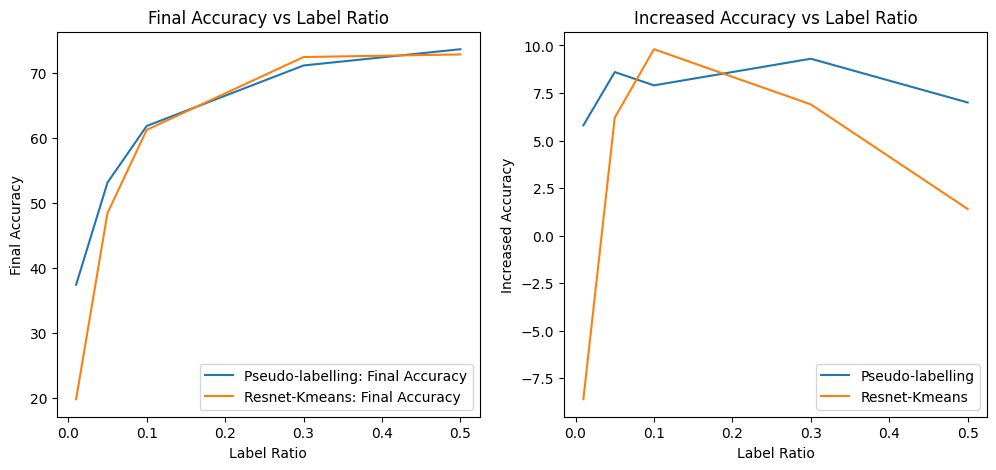

In [ ]:
df['Increased Accuracy'] = df['Final Accuracy'] - df['Initial Accuracy']
df1 = df[df['Method']=='Pseudo-labelling']
df2 = df[df['Method']=='Resnet-Kmeans']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(df1['Label Ratio'], df1['Final Accuracy'], label='Pseudo-labelling: Final Accuracy')
axs[0].plot(df2['Label Ratio'], df2['Final Accuracy'], label='Resnet-Kmeans: Final Accuracy')
axs[0].set_xlabel('Label Ratio')
axs[0].set_ylabel('Final Accuracy')
axs[0].set_title('Final Accuracy vs Label Ratio')
axs[0].legend()

axs[1].plot(df1['Label Ratio'], df1['Increased Accuracy'], label='Pseudo-labelling')
axs[1].plot(df2['Label Ratio'], df2['Increased Accuracy'], label='Resnet-Kmeans')
axs[1].set_xlabel('Label Ratio')
axs[1].set_ylabel('Increased Accuracy')
axs[1].set_title('Increased Accuracy vs Label Ratio')
axs[1].legend()

plt.show()

## Pseudo-Labelling
In the results and discussion section, we first analyze the performance of the Pseudo-labelling model. Regardless of the label_ratio settings, the final accuracy is consistently higher than the initial accuracy. As illustrated in the increased accuracy graph, the improvement in accuracy remains relatively stable at around 7.5% and exhibits an overall trend of first increasing and then decreasing. This implies that when the label ratio is low, the effect of pseudo-labeling is not optimal. As the label ratio increases, the improvement in accuracy generally rises. However, as the initial accuracy increases, the model's performance gradually approaches the best performance achievable using all data (75%-80%), thus leaving less room for improvement. Consequently, when the label ratio is 0.5, using pseudo-labelling results in an accuracy improvement of only 7%. Furthermore, the change in the labeled dataset's size is not directly correlated with the model's performance due to the quality of pseudo-labels. By comparing the cases where label_ratio is 0.01 and 0.05, we can observe that with a label_ratio of 0.1, pseudo-labelling adds a significant amount of labeled data, even more than when the label_ratio is 0.05, but the performance improvement is not outstanding. In addition, when label_ratio is 0.5, although only adding less than 5,000 labeled data points, the model's performance improves considerably.

## Resnet-Kmeans
Next, we examine the results of the ResNet-KMeans model. . However, the results reveal an issue: when label_ratio is 0.01, the ResNet-KMeans model does not perform well, even leading to a decline in performance. This issue was considered during our initial experiment and contributed to our adoption of the current model structure. In the present structure, the KMeans clustering loss is combined only after obtaining a trained ResNet, whereas the previous structure combined the KMeans clustering loss from the outset. The performance of the earlier model was significantly poorer, and the KMeans clustering loss hardly converged. We considered whether inappropriate learning rates, KMeans loss weights, initial centroids, or model complexity caused this issue, but after extensive testing and deliberation, we identified the problem. When training begins, the model performs poorly, resulting in weak deep feature representation capabilities. This implies that, at this stage, combining the KMeans clustering loss with cross-entropy is not meaningful and may even have adverse effects. Taking this issue into account, we modified the structure, allowing KMeans to be incorporated into training after the initial ResNet training. Although the new structure resolves the aforementioned issue, when the label ratio is extremely low, the model's performance remains poor even after initial training, rendering KMeans ineffective. This issue is absent when label_ratio is 0.05 or higher. Furthermore, we note that the improvement in accuracy in the ResNet-KMeans model also exhibits an overall trend of first increasing and then decreasing, with the highest increase at label_ratio 0.1. When label_ratio is 0.5, the improvement is minimal, possibly due to limited room for improvement caused by a higher initial accuracy.

## Comparison
Comparing both models, it is evident that the initial accuracies are generally similar across different label_ratios, as both methods employ the same supervised model (ResNet) structure, albeit influenced by randomness. The overall trend in accuracy improvement for both models is similar, with the improvement first increasing and then decreasing. The ResNet-KMeans model demonstrated slightly lower final accuracy than the Pseudo-labelling model. However, it is important to note that the training time for the ResNet-KMeans model was significantly shorter, as it only required one initial supervised model training and single-epoch iterations in subsequent steps.

Another aspect to consider in the comparison is the stability and consistency of the models. While Pseudo-labelling exhibited a more stable accuracy improvement across different label_ratios, the ResNet-KMeans model showed more variation, particularly struggling at extremely low label_ratios. Additionally, the impact of the quality of pseudo-labels on Pseudo-labelling performance and the limitations of ResNet-KMeans due to poor deep feature representation capabilities at low label_ratios highlight the specific challenges each model faces.

# Conclusion
In conclusion, both Pseudo-labelling and ResNet-KMeans models offer unique advantages and face certain limitations in semi-supervised learning. Pseudo-labelling provides consistent accuracy improvements across varying label_ratios but may require more computational resources due to the need to train a new supervised model in each iteration. On the other hand, the ResNet-KMeans model can achieve substantial accuracy improvements at higher label_ratios and offers a more efficient training process but may struggle with extremely low label_ratios.

The choice between these two approaches should be based on the specific requirements and constraints of a given problem and the available resources. It is crucial to consider factors such as computational efficiency, model stability, and performance consistency when selecting the appropriate semi-supervised learning model for a particular task.

# Future Study

In this study, due to time constraints and the focus on utilizing unlabeled data to improve model performance, our exploration of the supervised model structures might not have been exhaustive, and the models used might not be optimal. If given more time, we would attempt to further explore various model structures to achieve better performance. Additionally, we could perform multiple training runs for each label_ratio and take the average results to obtain more reliable outcomes.

Moreover, future research may investigate a broader range of semi-supervised learning model structures and examine the performance of different loss functions in this context. This study's time limitations also prevented us from thoroughly tuning the threshold for generating pseudo-labels and other hyperparameters, such as learning rate and batch size. Although we manually adjusted these parameters in several iterations, they might not be the best choices. Therefore, future studies could dedicate more time to hyperparameter tuning and optimization to enhance model performance.

Investigating the impact of different data distributions, noise levels, and data modalities on the performance of Pseudo-labelling and ResNet-KMeans models would also be valuable. Developing hybrid approaches that combine the strengths of both models, or incorporating other techniques such as active learning, could lead to more robust and efficient semi-supervised learning solutions. Finally, evaluating the practical utility and effectiveness of these models in various real-world applications, such as healthcare, finance, and natural language processing, could provide valuable insights into their potential use cases.